In [3]:
# Load the trained model

import torch
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from datasets import load_from_disk
from transformers import CLIPTokenizer, CLIPProcessor, AutoTokenizer
from transformers import AutoProcessor, FlavaModel
from PIL import Image
import base64
import io
import numpy as np

from tqdm.notebook import tqdm
import pandas as pd
from time import time

In [4]:
%load_ext autoreload
%autoreload 2

In [8]:
# from models.blip_exp2 import CustomBLIP,BLIPProcessDataset
# from models.blip_feasExtract import CustomBLIP,BLIPProcessDataset
# from models.blip_feasExtractCross import CustomBLIP,BLIPProcessDatasetZ
from models.blip2_feasExtract import CustomBLIP,BLIPProcessDataset
import torch

In [9]:
# model = torch.load('model_output/blip_entire_model_Salesforce-BlipForImageTextRetrieval-blip-itm-base-coco-epo6-25.pt')

model = torch.load('model_output/blip_entire_model_Salesforce-BlipModel-blip2-inn-concat-epo30.pt')



In [ ]:
model.eval()

CustomBLIP(
  (blip): Blip2Model(
    (vision_model): Blip2VisionModel(
      (embeddings): Blip2VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
      )
      (encoder): Blip2Encoder(
        (layers): ModuleList(
          (0): Blip2EncoderLayer(
            (self_attn): Blip2Attention(
              (dropout): Dropout(p=0.0, inplace=False)
              (qkv): Linear(in_features=1408, out_features=4224, bias=True)
              (projection): Linear(in_features=1408, out_features=1408, bias=True)
            )
            (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
            (mlp): Blip2MLP(
              (activation_fn): GELUActivation()
              (fc1): Linear(in_features=1408, out_features=6144, bias=True)
              (fc2): Linear(in_features=6144, out_features=1408, bias=True)
            )
            (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          )
          (1

In [ ]:
batch_size = 8

combined = load_from_disk('./processed_data/combined_hateful_memes_dataset')

train_data = combined['train']
train_dataset = BLIPProcessDataset(train_data)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

dev_seen_data = combined['dev_seen']
dev_seen_dataset = BLIPProcessDataset(dev_seen_data)
dev_seen_loader = DataLoader(dev_seen_dataset, shuffle=True, batch_size=batch_size)

dev_unseen_data = combined['dev_unseen']
dev_unseen_dataset = BLIPProcessDataset(dev_unseen_data)
dev_unseen_loader = DataLoader(dev_unseen_dataset, shuffle=True, batch_size=batch_size)

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

In [ ]:
def base64str_to_PILobj(base64_string):
    '''
    Args
    - base64_string (str): based64 encoded representing an image

    Output
    - PIL object (use .show() to display)
    '''
    image_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(image_data))
    #img.show()
    return img

In [ ]:
device='cuda'

In [ ]:
from tqdm.notebook import tqdm
import pandas as pd

def get_result_df(data_loader, sample_n=None, type_='train'):
    fina_res_dict_train = {
        'pred': [],
        'pred_score': [],
        'idx': [],
        'img': [],
        'labels': [],
        'type': []
    }

    with torch.no_grad():
        for batch in tqdm(data_loader):

            output = model(batch, device=device)
            predicted = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
            # _, predicted = nn.sigmoid(output)#torch.max(output.data, 1)

            fina_res_dict_train['pred'].extend(predicted.detach().cpu().numpy().reshape(-1).tolist())
            fina_res_dict_train['pred_score'].extend(output.detach().cpu().numpy().reshape(-1).tolist())
            fina_res_dict_train['idx'].extend(batch['idx_memes']) 
            fina_res_dict_train['labels'].extend(batch['labels'].detach().cpu().numpy().reshape(-1).tolist()) 
            fina_res_dict_train['img'].extend(batch['image'])
            fina_res_dict_train['type'].extend([type_ for _ in range(len(batch['image']))])
            
            # break
            if sample_n is not None and len(fina_res_dict_train['idx'])>=sample_n:
                break

    return pd.DataFrame(fina_res_dict_train)


In [ ]:
df = get_result_df(dev_unseen_loader, type_='dev_unseen')
df

  0%|          | 0/68 [00:00<?, ?it/s]

,pred,pred_score,idx,img,labels,type
0,0,0.038437,92567,iVBORw0KGgoAAAANSUhEUgAAAzkAAAI/CAIAAADbXoDnAA...,0,dev_unseen
1,0,0.043443,03214,iVBORw0KGgoAAAANSUhEUgAAAPwAAAGQCAIAAAAFiJqlAA...,0,dev_unseen
2,0,0.047428,76921,iVBORw0KGgoAAAANSUhEUgAAAzkAAAIlCAIAAAB5E6EaAA...,1,dev_unseen
3,0,0.022919,62035,iVBORw0KGgoAAAANSUhEUgAAAQoAAAGQCAIAAADZVLm7AA...,1,dev_unseen
4,1,0.526114,82197,iVBORw0KGgoAAAANSUhEUgAAAgAAAAFeCAYAAADzFKfgAA...,0,dev_unseen
...,...,...,...,...,...,...
535,0,0.021972,92738,iVBORw0KGgoAAAANSUhEUgAAAiYAAAFVCAIAAABU8rPjAA...,1,dev_unseen
536,0,0.055063,96180,iVBORw0KGgoAAAANSUhEUgAAAqgAAAMgCAIAAABgTgcKAA...,1,dev_unseen
537,0,0.082011,26530,iVBORw0KGgoAAAANSUhEUgAAAgAAAAFkCAAAAABzntz3AA...,0,dev_unseen
538,1,0.888350,61872,iVBORw0KGgoAAAANSUhEUgAAAcMAAAMgCAIAAADQq56MAA...,1,dev_unseen


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(df['labels'], df['pred_score'])

0.7155441176470588

In [19]:
df[df['pred']==df['labels']]

,pred,idx,img,labels,type
1,0,47950,iVBORw0KGgoAAAANSUhEUgAAAzkAAAIlCAIAAAB5E6EaAA...,0,dev_unseen
2,0,38195,iVBORw0KGgoAAAANSUhEUgAAAgAAAAPCCAYAAAAOL2DxAA...,0,dev_unseen
4,0,38914,iVBORw0KGgoAAAANSUhEUgAAAzkAAAIlCAIAAAB5E6EaAA...,0,dev_unseen
5,0,93425,iVBORw0KGgoAAAANSUhEUgAAAgAAAAFVCAYAAACZ01cjAA...,0,dev_unseen
6,0,84102,iVBORw0KGgoAAAANSUhEUgAAAQoAAAGQCAIAAADZVLm7AA...,0,dev_unseen
...,...,...,...,...,...
533,0,48973,iVBORw0KGgoAAAANSUhEUgAAAgAAAAGkCAYAAABHHZ2fAA...,0,dev_unseen
535,0,86195,iVBORw0KGgoAAAANSUhEUgAAAiYAAAGwCAIAAAASeznSAA...,0,dev_unseen
537,0,52104,iVBORw0KGgoAAAANSUhEUgAAATUAAAGQCAIAAABArGAOAA...,0,dev_unseen
538,0,14270,iVBORw0KGgoAAAANSUhEUgAAAgAAAAFVCAYAAACZ01cjAA...,0,dev_unseen


In [20]:
failed_df = df[df['pred']!=df['labels']]

In [21]:
failed_df

,pred,idx,img,labels,type
0,0,72048,iVBORw0KGgoAAAANSUhEUgAAAisAAAMfCAIAAACYUABwAA...,1,dev_unseen
3,0,03519,iVBORw0KGgoAAAANSUhEUgAAAiYAAAFtCAIAAAC82zYjAA...,1,dev_unseen
8,0,17682,iVBORw0KGgoAAAANSUhEUgAAAQoAAAGQCAIAAADZVLm7AA...,1,dev_unseen
12,0,29750,iVBORw0KGgoAAAANSUhEUgAAAQkAAAGPCAIAAADA47L2AA...,1,dev_unseen
13,0,46971,iVBORw0KGgoAAAANSUhEUgAAARQAAAGQCAIAAADgMwjgAA...,1,dev_unseen
...,...,...,...,...,...
525,0,35840,iVBORw0KGgoAAAANSUhEUgAAAiYAAAFtCAIAAAC82zYjAA...,1,dev_unseen
527,0,45702,iVBORw0KGgoAAAANSUhEUgAAAzkAAAIlCAIAAAB5E6EaAA...,1,dev_unseen
528,0,02783,iVBORw0KGgoAAAANSUhEUgAAAiYAAAHQCAIAAAAajzaIAA...,1,dev_unseen
534,0,74906,iVBORw0KGgoAAAANSUhEUgAAAnIAAAMgCAIAAAAofRiKAA...,1,dev_unseen


In [23]:
# train_data.data#[train_data['id']==36098]

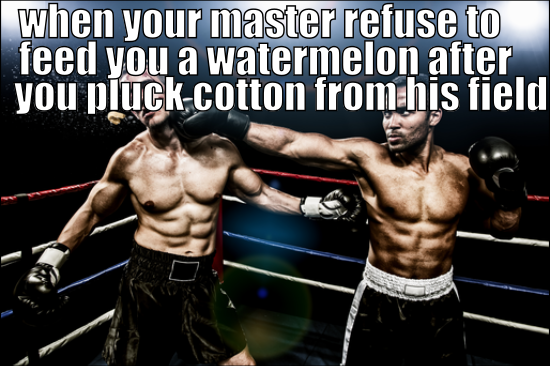

In [60]:
base64str_to_PILobj(failed_df['img'].iloc[0])

In [25]:


time()

1712937471.5314844

In [26]:
device = 'cuda'#'cuda' if torch.cuda.is_available() else 'cpu'
model.eval()
correct_normal = 0
total = 0
model = model.to(device)
accuracy = {}
fina_res_dict = {
    'pred': [],
    'pred_score': [],
    'idx': [],
    'img': [],
    'labels': [],
    'type': []
}
gen_df = True

t0 = time()
with torch.no_grad():
    for batch in tqdm(dev_seen_loader):
        # print(batch)
        # input_ids = batch['input_ids'].to(device)
        # #token_type_ids  = batch['token_type_ids'].to(device)
        # attention_mask = batch['attention_mask'].to(device)
        # pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        output = model(batch, device=device)
        predicted = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
        # _, predicted = nn.sigmoid(output)#torch.max(output.data, 1)

        total += labels.size(0)
        this_batch_corrected = (predicted==labels.reshape(-1,1)).sum().item()
        correct_normal += this_batch_corrected
        # print(f'{this_batch_corrected}/{labels.size(0)} correct for this batch. total corrected by far={correct_normal}/{total}')
        # break
        if gen_df:
            fina_res_dict['pred'].extend(predicted.detach().cpu().numpy().reshape(-1).tolist())
            fina_res_dict['pred_score'].extend(output.detach().cpu().numpy().reshape(-1).tolist())
            fina_res_dict['idx'].extend(batch['idx_memes']) 
            fina_res_dict['labels'].extend(batch['labels'].detach().cpu().numpy().reshape(-1).tolist()) 
            fina_res_dict['img'].extend(batch['image'])
            fina_res_dict['type'].extend(['dev_seen' for _ in range(len(batch['image']))])
        # break
    accuracy['dev_seen'] = correct_normal/total
print(f"dev_seen completed in {(time()-t0):.2f}s. total count={total}. Accuracy={accuracy['dev_seen']}")

correct_normal = 0
total = 0
t0 = time()
with torch.no_grad():
    for batch in tqdm(dev_unseen_loader):
        # print(batch)
        # input_ids = batch['input_ids'].to(device)
        # #token_type_ids  = batch['token_type_ids'].to(device)
        # attention_mask = batch['attention_mask'].to(device)
        # pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        output = model(batch, device=device)
        predicted = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
        # _, predicted = nn.sigmoid(output)#torch.max(output.data, 1)

        total += labels.size(0)
        this_batch_corrected = (predicted==labels.reshape(-1,1)).sum().item()
        correct_normal += this_batch_corrected
        # print(f'{this_batch_corrected}/{labels.size(0)} correct for this batch. total corrected by far={correct_normal}/{total}')
        # break
        if gen_df:
            fina_res_dict['pred'].extend(predicted.detach().cpu().numpy().reshape(-1).tolist())
            fina_res_dict['pred_score'].extend(output.detach().cpu().numpy().reshape(-1).tolist())
            fina_res_dict['idx'].extend(batch['idx_memes']) 
            fina_res_dict['labels'].extend(batch['labels'].detach().cpu().numpy().reshape(-1).tolist()) 
            fina_res_dict['img'].extend(batch['image'])
            fina_res_dict['type'].extend(['dev_unseen' for _ in range(len(batch['image']))])
        # break
    accuracy['dev_unseen'] = correct_normal/total

print(f"dev_unseen completed {(time()-t0):.2f}s. total count={total}. Accuracy={accuracy['dev_unseen']}")
correct_normal = 0
total = 0
t0 = time()
with torch.no_grad():
    for batch in tqdm(train_loader):
        # print(batch)
        # input_ids = batch['input_ids'].to(device)
        # #token_type_ids  = batch['token_type_ids'].to(device)
        # attention_mask = batch['attention_mask'].to(device)
        # pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        output = model(batch, device=device)
        predicted = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
        # _, predicted = nn.sigmoid(output)#torch.max(output.data, 1)

        total += labels.size(0)
        this_batch_corrected = (predicted==labels.reshape(-1,1)).sum().item()
        correct_normal += this_batch_corrected
        # print(f'{this_batch_corrected}/{labels.size(0)} correct for this batch. total corrected by far={correct_normal}/{total}')

        if gen_df:
            fina_res_dict['pred'].extend(predicted.detach().cpu().numpy().reshape(-1).tolist())
            fina_res_dict['pred_score'].extend(output.detach().cpu().numpy().reshape(-1).tolist())
            fina_res_dict['idx'].extend(batch['idx_memes']) 
            fina_res_dict['labels'].extend(batch['labels'].detach().cpu().numpy().reshape(-1).tolist()) 
            fina_res_dict['img'].extend(batch['image'])
            fina_res_dict['type'].extend(['train' for _ in range(len(batch['image']))])
        # break

        # break
    accuracy['train'] = correct_normal/total
print(f"train completed {(time()-t0):.2f}s. total count={total}. Accuracy={accuracy['train']}")


  0%|          | 0/63 [00:00<?, ?it/s]

dev_seen completed in 50.39s. total count=500. Accuracy=0.57


  0%|          | 0/68 [00:00<?, ?it/s]

dev_unseen completed 53.94s. total count=540. Accuracy=0.6148148148148148


  0%|          | 0/1063 [00:00<?, ?it/s]

train completed 678.44s. total count=8500. Accuracy=0.7216470588235294


In [27]:
df = pd.DataFrame(fina_res_dict)
df


,pred,pred_score,idx,img,labels,type
0,1,0.547448,40982,iVBORw0KGgoAAAANSUhEUgAAAiYAAAGcCAIAAABiFfyfAA...,1,dev_seen
1,0,0.056417,69512,iVBORw0KGgoAAAANSUhEUgAAAi4AAAMgCAIAAACLVX5MAA...,0,dev_seen
2,0,0.345561,87130,iVBORw0KGgoAAAANSUhEUgAAAxYAAAMgCAIAAAAx/2NAAA...,1,dev_seen
3,1,0.508052,02634,iVBORw0KGgoAAAANSUhEUgAAAiYAAAG0CAIAAACJ6nvEAA...,1,dev_seen
4,0,0.427041,02143,iVBORw0KGgoAAAANSUhEUgAAASwAAAGQCAIAAACbF8osAA...,1,dev_seen
...,...,...,...,...,...,...
9535,0,0.243726,53068,iVBORw0KGgoAAAANSUhEUgAAAiYAAAFuCAIAAAA6T0SNAA...,0,train
9536,1,0.640602,09768,iVBORw0KGgoAAAANSUhEUgAAAiYAAAFuCAIAAAA6T0SNAA...,1,train
9537,1,0.621353,83571,iVBORw0KGgoAAAANSUhEUgAAAyAAAAIVCAIAAACm0gyVAA...,0,train
9538,1,0.569455,32570,iVBORw0KGgoAAAANSUhEUgAAAhUAAAMgCAIAAAAbRgeDAA...,0,train


In [28]:

from sklearn.metrics import roc_auc_score

# blip_entire_model_Salesforce-BlipForImageTextRetrieval-blip-itm-base-coco-new.pt
for type_ in ['train', 'dev_seen', 'dev_unseen']:
    temp_df = df[df['type']==type_]
    auc = roc_auc_score(temp_df['labels'], temp_df['pred_score'])
    print('%s AUC: %.3f' % (type_,auc))

accuracy

train AUC: 0.767
dev_seen AUC: 0.632
dev_unseen AUC: 0.627


{'dev_seen': 0.57,
 'dev_unseen': 0.6148148148148148,
 'train': 0.7216470588235294}

In [26]:
fina_res_dict.keys()

dict_keys(['pred', 'idx', 'img', 'labels', 'type'])

In [29]:
len(fina_res_dict['pred']), len(fina_res_dict['idx']), len(fina_res_dict['img']), len(fina_res_dict['labels']), len(fina_res_dict['type'])

(9540, 9540, 9540, 9540, 7164)

In [ ]:
accuracy # dev_unseen with blip_entire_model_blip-vqa-base.pt

0.6185185185185185

In [23]:
accuracy # dev_seen with blip_entire_model_blip-vqa-base.pt

0.516

In [16]:
accuracy # dev_seen with blip_entire_model.pt

0.494

In [35]:
accuracy # dev_unseen with blip_entire_blip_entire_model_blip-itm-base-coco.pt

0.6240740740740741

In [38]:
accuracy # dev_seen with blip_entire_blip_entire_model_blip-itm-base-coco.pt

0.502

In [17]:
accuracy # dev seen blip_entire_model_Salesforce-blip-vqa-base-concat.pt

0.56

In [20]:
accuracy # dev unseen blip_entire_model_Salesforce-blip-vqa-base-concat.pt

0.6481481481481481

In [28]:
accuracy # blip_entire_model_Salesforce-blip-vqa-base-concat.pt

{'dev_seen': 0.56, 'dev_unseen': 0.6057692307692307}

In [15]:
accuracy # blip_entire_model_Salesforce-blip-vqa-base-concat-flatten.pt

{'dev_seen': 0.57, 'dev_unseen': 0.5932692307692308}

In [36]:
accuracy # blip_entire_model_Salesforce-blip-vqa-base-concat-flatten-dropout0_4.pt

{'dev_seen': 0.558, 'dev_unseen': 0.5913461538461539}

In [11]:
accuracy # blip_entire_model_Salesforce-blip-itm-base-coco-concat-epo15.pt'

{'dev_seen': 0.494, 'dev_unseen': 0.42980769230769234}

In [29]:
accuracy # blip_entire_model_Salesforce-blip-itm-base-coco-concat-epo15-unfreeze-train.pt

{'dev_seen': 0.57,
 'dev_unseen': 0.6096153846153847,
 'train': 0.830083857442348}

In [9]:
accuracy # blip_entire_model_Salesforce-blip-itm-base-coco-concat-epo15-unfreeze-train-epo15-30.pt

{'dev_seen': 0.604,
 'dev_unseen': 0.6269230769230769,
 'train': 0.8430817610062893}

In [22]:
accuracy # blip_entire_model_Salesforce-blip-itm-base-coco-concat-2ndAttempt.pt

{'dev_seen': 0.546, 'dev_unseen': 0.5875, 'train': 0.7072327044025157}

In [37]:
accuracy # BlipForImageTextRetrieval-blip-itm-base-coco-concat.pt

{'dev_seen': 0.546,
 'dev_unseen': 0.6259259259259259,
 'train': 0.7218823529411764}

In [27]:
accuracy # blip_entire_model_Salesforce-BlipForImageTextRetrieval-blip-itm-base-coco-concat-epo6-10.pt

{'dev_seen': 0.506,
 'dev_unseen': 0.6296296296296297,
 'train': 0.6448235294117647}

In [38]:
accuracy # blip_entire_model_Salesforce-BlipForImageTextRetrieval-blip-itm-base-coco.pt

{'dev_seen': 0.506,
 'dev_unseen': 0.6296296296296297,
 'train': 0.6448235294117647}

In [54]:
accuracy # blip_entire_model_Salesforce-BlipForImageTextRetrieval-blip-itm-base-coco-epo6-25.pt

{'dev_seen': 0.596,
 'dev_unseen': 0.6537037037037037,
 'train': 0.8941176470588236}

In [21]:
batch['idx_memes']

['63957', '10478', '93102', '45609']

In [35]:
fina_res_dict_train = {
    'pred': [],
    'idx': [],
    'img': [],
    'label': []
}
        # fina_res_dict_train['pred'].extend(batch['pred'])
        # fina_res_dict_train['idx'].extend(batch['idx'])
        # fina_res_dict_train['img'].extend(batch['img'])
        # fina_res_dict_train['label'].extend(batch['label'])
fina_res_dict_train


{'pred': [], 'idx': [], 'img': [], 'label': []}

In [36]:
fina_res_dict_train['pred'].extend(predicted.detach().cpu().numpy().reshape(-1).tolist())
fina_res_dict_train['idx'].extend(batch['idx_memes']) 
fina_res_dict_train['labels'].extend(batch['labels'].detach().cpu().numpy().reshape(-1).tolist()) 
fina_res_dict_train['img'].extend(batch['image'])



In [39]:
batch.keys()#['idx']

dict_keys(['pixel_values', 'input_ids', 'attention_mask', 'labels', 'idx_memes', 'image'])

In [37]:
fina_res_dict_train

{'pred': [0, 0, 0, 0], 'idx': [], 'img': [], 'label': []}

In [34]:
predicted.detach().cpu().numpy().reshape(-1).tolist()

[0, 0, 0, 0]

In [103]:
output.data

tensor([[0.1624],
        [0.7426],
        [0.3069],
        [0.1408]], device='cuda:0')